In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# Prepare dataset

In [2]:
train_sessions = pd.read_csv(
    'train_sessions.csv',
    parse_dates=['date'], 
    infer_datetime_format=True
    )
train_bought= pd.read_csv(
    'train_purchases.csv',
    parse_dates=['date'], 
    infer_datetime_format=True
    )
train_sessions =pd.concat([train_sessions,train_bought])

In [3]:
test_sessions = pd.read_csv(
    'test_final_sessions.csv',
    parse_dates=['date'], 
    infer_datetime_format=True
    )
test_sessions_lb = pd.read_csv(
    'test_leaderboard_sessions.csv',
    parse_dates=['date'], 
    infer_datetime_format=True
    )
test_sessions=pd.concat([test_sessions,test_sessions_lb])

In [4]:
session_list = train_sessions[['session_id', 'item_id']].groupby(['session_id']).agg(tuple).applymap(list).reset_index()
session_date = train_sessions[['session_id', 'date']].groupby(['session_id']).agg(['min','max',"mean"]).reset_index()

session_list.rename({"item_id":"session"})

,session_id,item_id
0,3,"[9769, 9769, 12492]"
1,13,"[12783, 3299]"
2,18,"[14116, 6166, 6924, 17411]"
3,19,"[4546, 8092, 17752, 14975, 9083, 9079, 7096, 8..."
4,24,"[6381, 10784, 6381, 23669, 5215, 2842, 10162, ..."
...,...,...
999995,4439986,"[2464, 3424, 2381, 4167, 4902, 2204, 554]"
999996,4439990,"[5648, 15997, 1425, 3037, 5523, 6925, 13664, 6..."
999997,4439994,"[4493, 3836]"
999998,4439999,"[11487, 9163, 5607, 6006, 7907, 1539, 12884, 1..."


In [5]:
session_date.columns = session_date.columns.droplevel()
session_date.columns = ["session_id","min","max","mean"]
#remove min from mean to get average time distance between clicks


In [96]:
session=session_date.merge(session_list,how="left",on="session_id")

In [97]:
session["length_all"]=session["item_id"].apply(lambda x: len(x))
session["length_unique"]=session["item_id"].apply(lambda x: len(set(x)))
session["repeated_count"] = session["length_all"] -session["length_unique"]
session["mean"] = (session_date["max"]-session_date["min"])/session["length_all"]
session["month"] =session["min"].dt.month
session["year"] =session["min"].dt.year
session["day_of_week"] = session["min"].dt.dayofweek
session["hour_start"] = session["min"].dt.hour
session["hour_end"]  = session["max"].dt.hour
session["length"] = session["max"]-session["min"]

In [98]:
session["mean_minutes"]=(session["mean"].dt.total_seconds()/60).astype(int)
session["length_hours"]=(session["length"].dt.total_seconds()/3600).astype(int)
session["length_minutes"]=(session["length"].dt.total_seconds()/60).astype(int)


In [9]:
session.head()

,session_id,min,max,mean,item_id,length_all,length_unique,repeated_count,month,year,day_of_week,hour_start,hour_end,length,mean_minutes,length_hours,length_minutes
0,3,2020-12-18 21:19:48.093,2020-12-18 21:26:47.986,0 days 00:02:19.964333333,"[9769, 9769, 12492]",3,2,1,12,2020,4,21,21,0 days 00:06:59.893000,2,0,6
1,13,2020-03-13 19:35:27.136,2020-03-13 19:36:15.507,0 days 00:00:24.185500,"[12783, 3299]",2,2,0,3,2020,4,19,19,0 days 00:00:48.371000,0,0,0
2,18,2020-08-26 19:15:47.232,2020-08-26 19:20:32.049,0 days 00:01:11.204250,"[14116, 6166, 6924, 17411]",4,4,0,8,2020,2,19,19,0 days 00:04:44.817000,1,0,4
3,19,2020-11-02 16:30:36.378,2020-11-02 17:16:45.920,0 days 00:02:33.863444444,"[4546, 8092, 17752, 14975, 9083, 9079, 7096, 8...",18,18,0,11,2020,0,16,17,0 days 00:46:09.542000,2,0,46
4,24,2020-02-26 17:22:48.903,2020-02-26 18:27:44.114,0 days 00:06:29.521100,"[6381, 10784, 6381, 23669, 5215, 2842, 10162, ...",10,9,1,2,2020,2,17,18,0 days 01:04:55.211000,6,1,64


# Important Datetimes

In [10]:
session["min"].min()

Timestamp('2020-01-01 00:00:01.359000')

In [11]:
session["min"].max()

Timestamp('2021-05-31 23:41:09.230000')

Split validation as last month ?  get sessions up to 2021-04-31 ? 

# Datetime distributions

## Hour of day Distribution

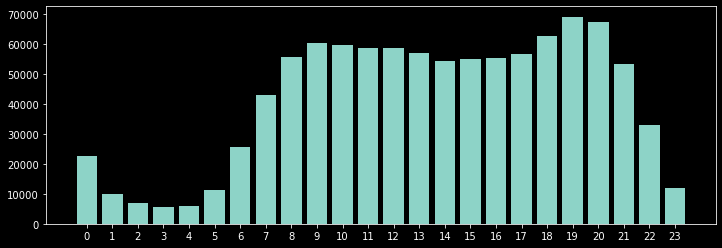

In [12]:
fig, axs = plt.subplots(figsize=(12, 4))
temp=session.groupby(session["hour_start"]).count()[["session_id"]]

plt.bar(temp.index,temp["session_id"])
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

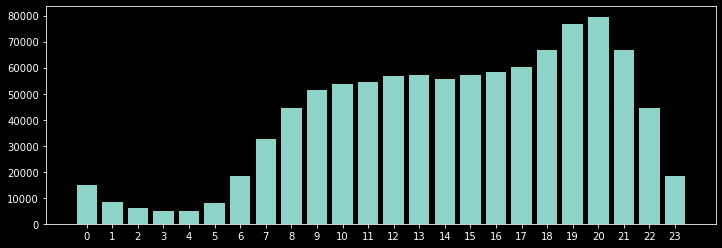

In [13]:
fig, axs = plt.subplots(figsize=(12, 4))
temp=session.groupby(session["hour_end"]).count()[["session_id"]]

plt.bar(temp.index,temp["session_id"])
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

## Weekday distribution

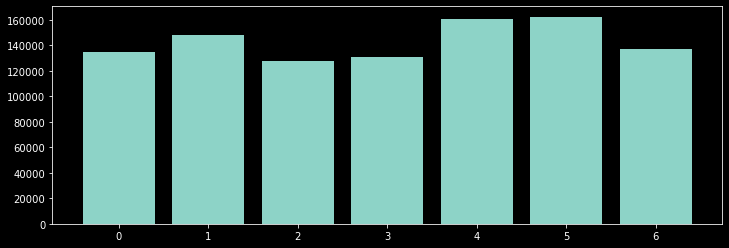

In [14]:
fig, axs = plt.subplots(figsize=(12, 4))
temp=session.groupby(session["day_of_week"]).count()[["session_id"]]

plt.bar(temp.index,temp["session_id"])
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

## Month Distribution


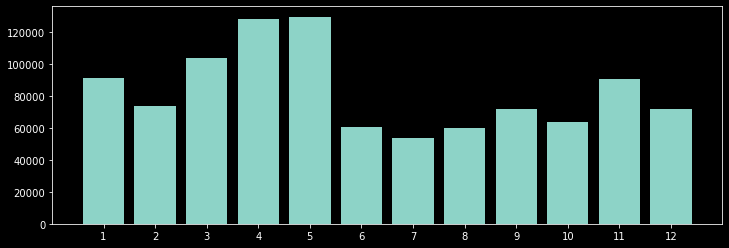

In [15]:
fig, axs = plt.subplots(figsize=(12, 4))
temp=session.groupby(session["month"]).count()[["session_id"]]

plt.bar(temp.index,temp["session_id"])
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

## Distinguishing between two years

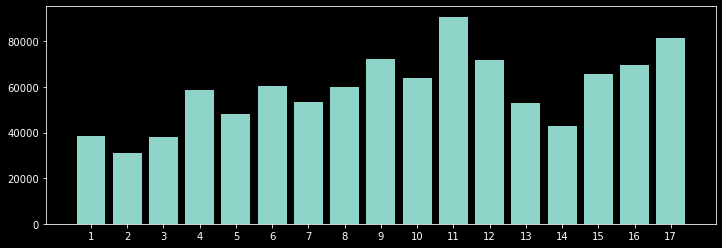

In [16]:
fig, axs = plt.subplots(figsize=(12, 4))
temp=session.groupby([session["month"],session["year"]]).count()[["session_id"]].reset_index(level=[0,1])
temp["month_year"]=temp["month"]+(temp["year"]-2020)*12
plt.bar(temp["month_year"],temp["session_id"])
plt.xticks(np.arange(min(temp["month_year"]), max(temp["month_year"])+1, 1.0))
plt.show()

## Average click distance

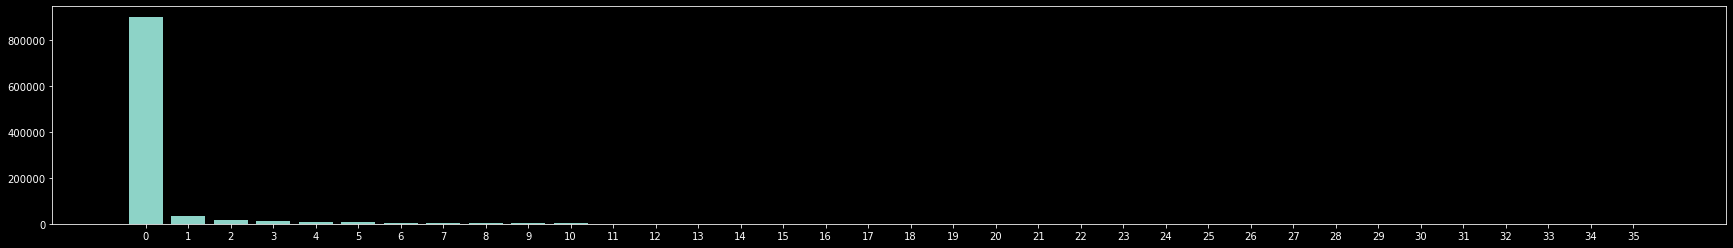

In [17]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby((session["mean_minutes"]/20).astype(int)).count()[["session_id"]]

plt.bar(temp.index,(temp["session_id"]))
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

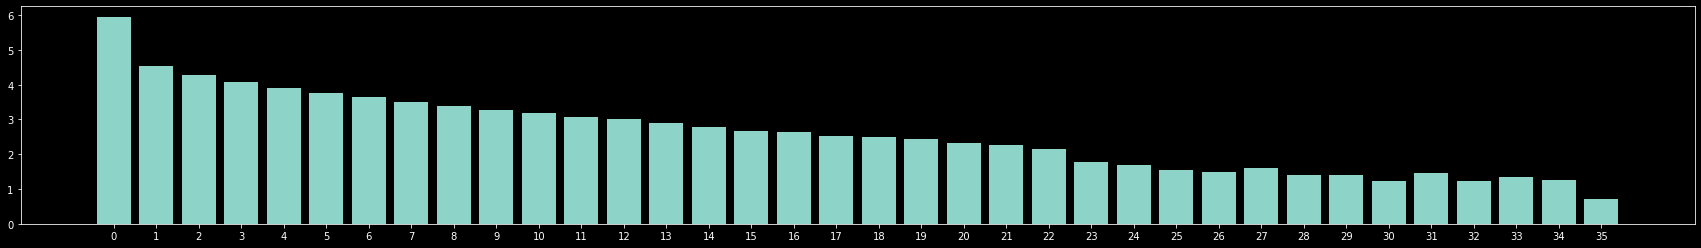

In [18]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby((session["mean_minutes"]/20).astype(int)).count()[["session_id"]]

plt.bar(temp.index,np.log10(temp["session_id"]))
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

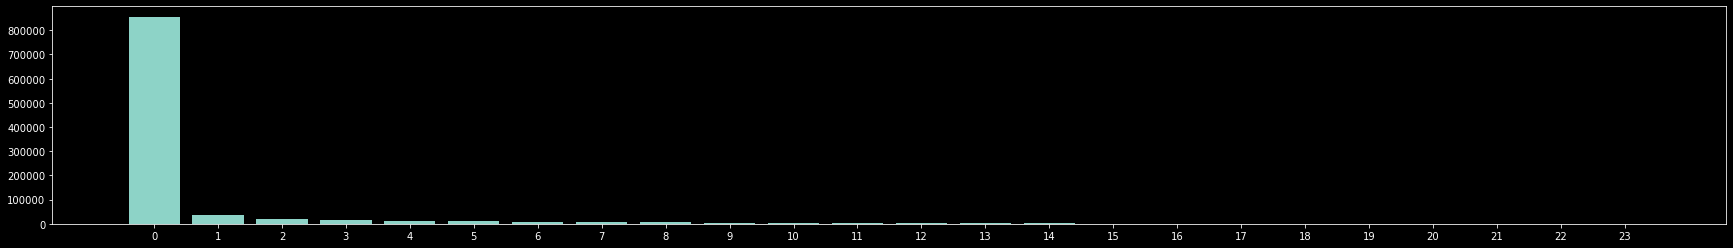

In [19]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby((session["length_hours"]).astype(int)).count()[["session_id"]]

plt.bar(temp.index,(temp["session_id"]))
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

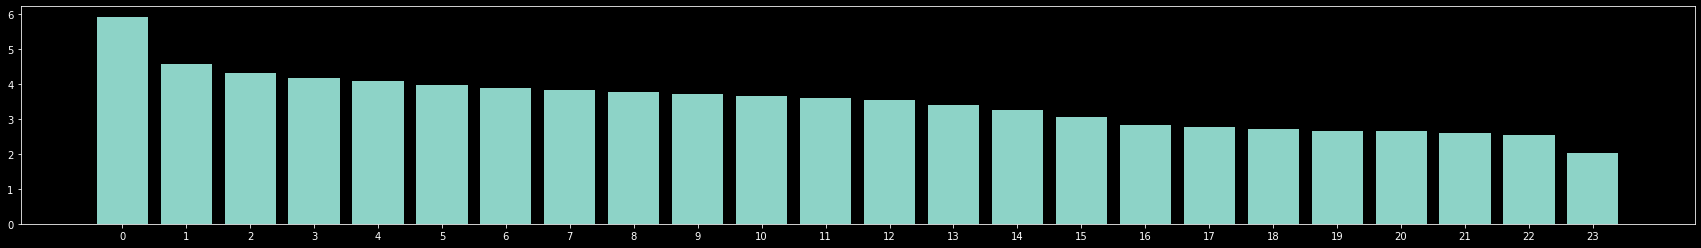

In [20]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby((session["length_hours"]).astype(int)).count()[["session_id"]]

plt.bar(temp.index,np.log10(temp["session_id"]))
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

# Distribution of lengths

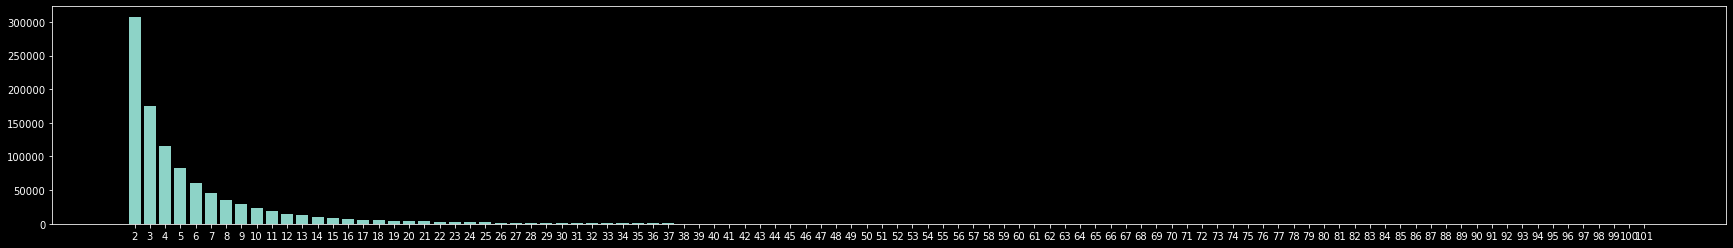

In [21]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby(session["length_all"]).count()[["session_id"]]

plt.bar(temp.index,temp["session_id"])
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

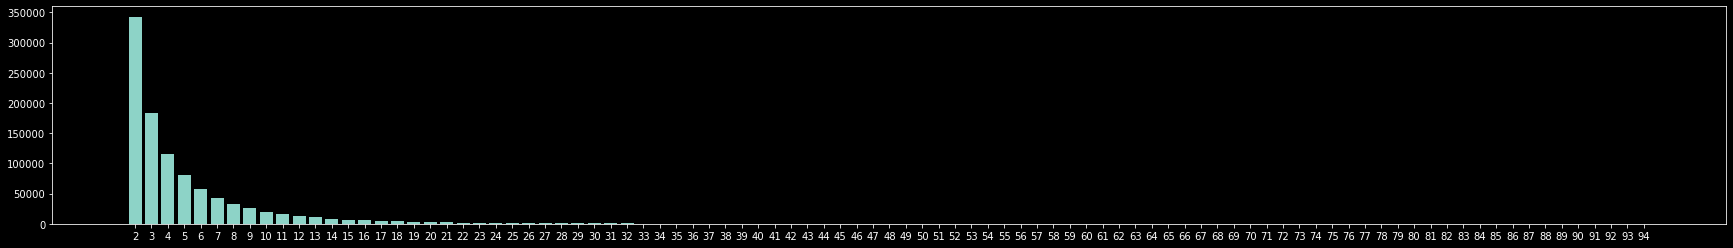

In [22]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby(session["length_unique"]).count()[["session_id"]]

plt.bar(temp.index,temp["session_id"])
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

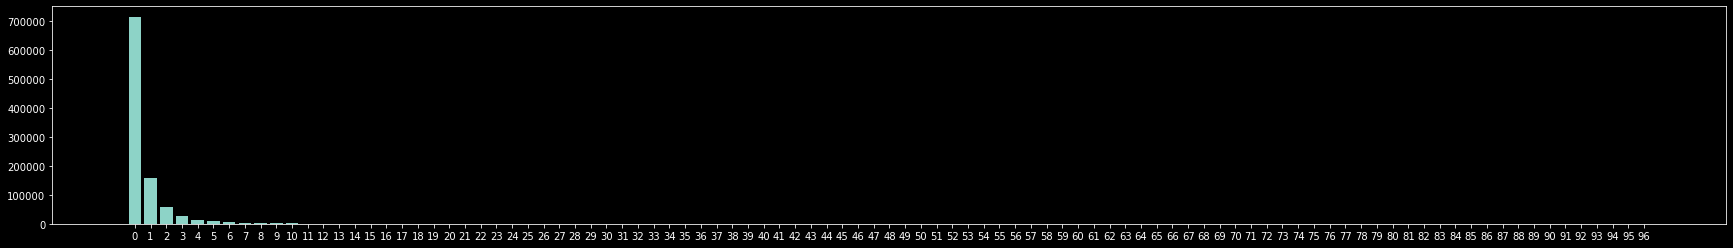

In [23]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby(session["repeated_count"]).count()[["session_id"]]

plt.bar(temp.index,temp["session_id"])
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

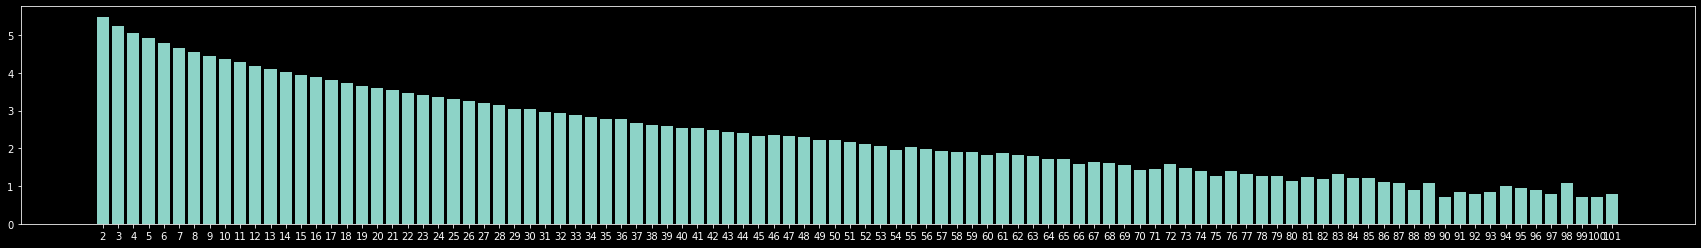

In [24]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby(session["length_all"]).count()[["session_id"]]

plt.bar(temp.index,np.log10(temp["session_id"]))
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

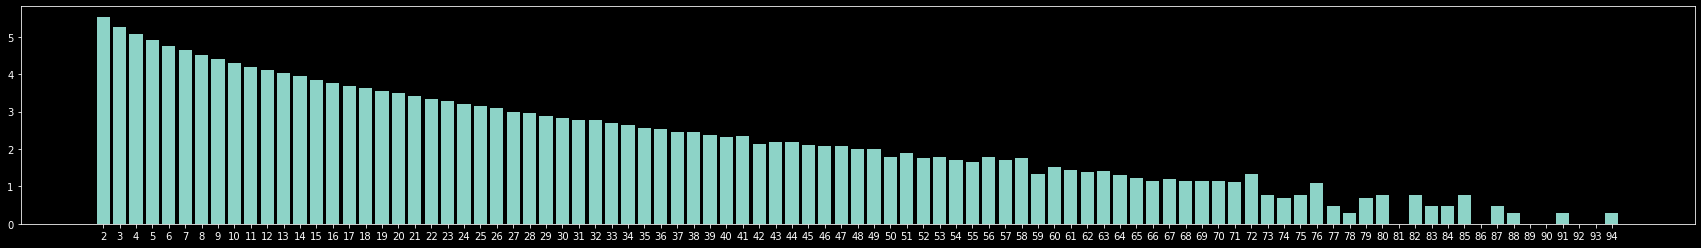

In [25]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby(session["length_unique"]).count()[["session_id"]]

plt.bar(temp.index,np.log10(temp["session_id"]))
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

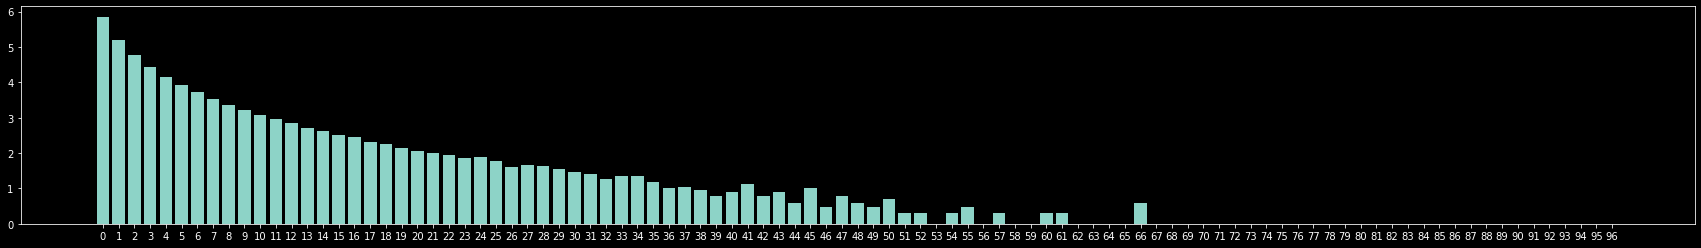

In [26]:
fig, axs = plt.subplots(figsize=(30, 4))
temp=session.groupby(session["repeated_count"]).count()[["session_id"]]

plt.bar(temp.index,np.log10(temp["session_id"]))
plt.xticks(np.arange(min(temp.index), max(temp.index)+1, 1.0))
plt.show()

# Popularity in session

## Frequency of item_ids

In [27]:
train_sessions["value"]=1
test_sessions["value"]=1

In [28]:
items=train_sessions.groupby("item_id")["value"].count().reset_index()

In [29]:
items=items.sort_values(by="value",ascending=False)

In [30]:
items["log_value"]=np.log(items["value"])

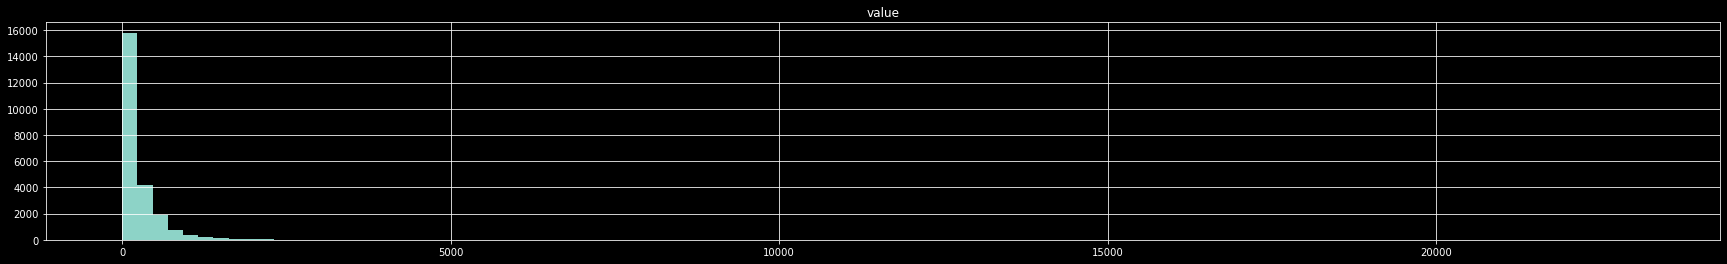

In [31]:
hist=items.hist(column="value",bins=100,figsize=(30, 4))

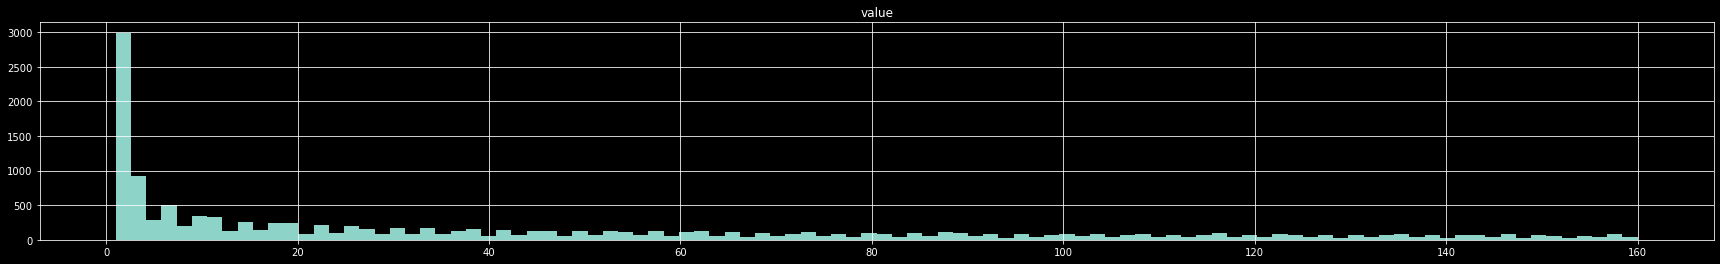

In [32]:
hist=items[10000:].hist(column="value",bins=100,figsize=(30, 4))

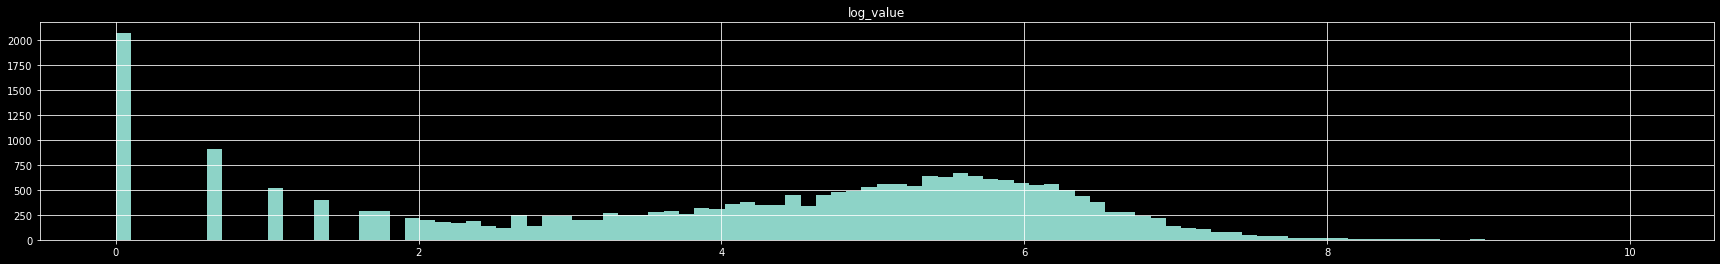

In [33]:
hist=items.hist(column="log_value",bins=100,figsize=(30, 4))

## TopPop Analisis

In [34]:
top_pop_general=items["item_id"][:100].values.tolist()

In [35]:
for item in top_pop_general:
    print(str(item)+",",end=" ")
print()


1468, 4741, 6135, 3526, 9262, 323, 3037, 3229, 2115, 1449, 3676, 6925, 16491, 1659, 5960, 786, 1227, 3531, 3833, 554, 3746, 4810, 4411, 1393, 4714, 3060, 4878, 2734, 3306, 4870, 540, 1609, 2180, 200, 2549, 190, 772, 4935, 6006, 3586, 11075, 4213, 2577, 2466, 1869, 4631, 3400, 3867, 917, 4796, 4645, 4026, 6345, 270, 4007, 3004, 2694, 9661, 2233, 3362, 2842, 11761, 8828, 3844, 3886, 2674, 18733, 4158, 407, 3656, 3318, 10479, 2149, 2954, 11658, 1458, 2780, 2546, 17081, 1584, 2530, 10738, 4503, 3155, 1725, 1285, 2638, 1336, 4846, 2320, 5215, 4057, 13765, 4036, 7597, 3095, 2302, 15531, 3783, 421, 


In [36]:
train_sessions["month"] =train_sessions["date"].dt.month
train_sessions["year"] =train_sessions["date"].dt.year

In [37]:
monthly_ds=train_sessions.groupby(["month","year","item_id"])["value"].count().reset_index()

In [38]:
monthly_ds

,month,year,item_id,value
0,1,2020,30,27
1,1,2020,34,1
2,1,2020,62,4
3,1,2020,108,6
4,1,2020,186,80
...,...,...,...,...
124354,12,2020,23591,1
124355,12,2020,23595,1
124356,12,2020,23635,5
124357,12,2020,23655,1


In [39]:
top_pops={}
top_pops["general"]=top_pop_general

In [40]:
for year in range(2):
    year=year+2020
    for month in range(12):
        month+=1
        if year==2021 and month>5:
            break
        
        ds=monthly_ds[monthly_ds["month"]==month]
        ds=ds[ds["year"]==year]
        ds=ds.sort_values(by="value",ascending=False)
        top_pops[f"{month}/{year}"]=ds["item_id"][:100].values.tolist()

In [41]:
seen=[]
heatmap=np.zeros((len(top_pops.keys()),len(top_pops.keys())))
for x,i in enumerate(top_pops.keys()):
    for y,j in enumerate(top_pops.keys()):
        seen.append(i)
        if j not in seen:
            count=0
            for item in top_pops[i]:
                if item in top_pops[j]:
                    count+=1
            #print(f"items_in_common between {i} and {j}: {count}")
            heatmap[x,y]=count
            heatmap[y,x]=count

In [42]:
top_pops.keys()

dict_keys(['general', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021'])

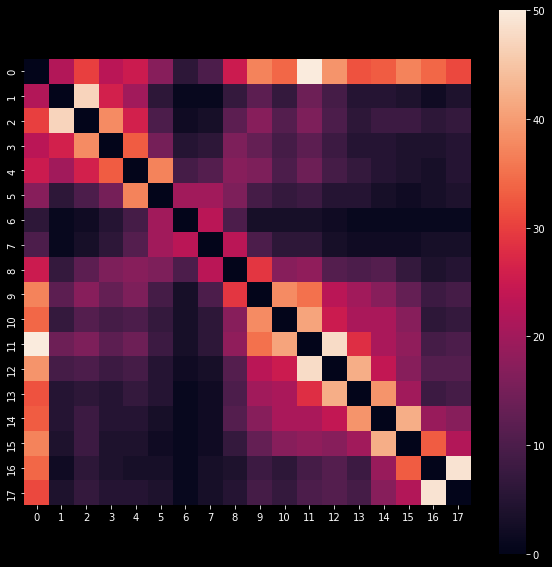

In [43]:
#0 is overall top_popular_list
#other numbers are the index of the month starting from january 2020 up to may 2021
#We can see that general top pop is close to november 2020 -> this can be due to the fact that is the month with most sessions
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(heatmap, square=True)

## Added test set to heatmap

In [44]:
items_test=test_sessions.groupby("item_id")["value"].count().reset_index()
items_test=items_test.sort_values(by="value",ascending=False)
top_pop_test=items_test["item_id"][:100].values.tolist()

In [45]:
heatmap_test=np.zeros((len(top_pops.keys())+1,len(top_pops.keys())+1))

In [46]:
heatmap_test[:-1,:-1]=heatmap

In [47]:
for x,i in enumerate(top_pops.keys()):
    count=0
    for item in top_pops[i]:
        if item in top_pop_test:
            count+=1
    heatmap_test[-1,x] = count
    heatmap_test[x,-1] = count

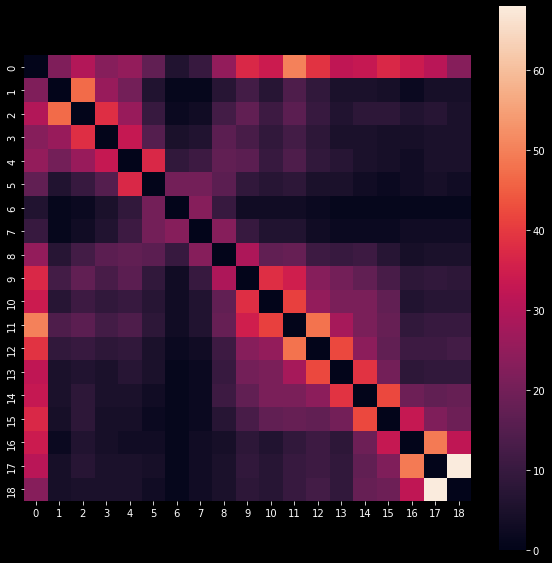

In [48]:
#last row/column are test set interaction top_pop
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(heatmap_test, square=True)

# Popularity in session removing duplicates from sessions

## Frequency of item_ids

In [49]:
train_sessions["value"]=1
test_sessions["value"]=1
train_sessions_no_duplicates=train_sessions[["item_id","session_id","value"]]
test_sessions_no_duplicates=test_sessions[["item_id","session_id","value"]]
train_sessions_no_duplicates.drop_duplicates(inplace=True)
test_sessions_no_duplicates.drop_duplicates(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [50]:
items=train_sessions_no_duplicates.groupby("item_id")["value"].count().reset_index()

In [51]:
items=items.sort_values(by="value",ascending=False)

In [52]:
items["log_value"]=np.log(items["value"])

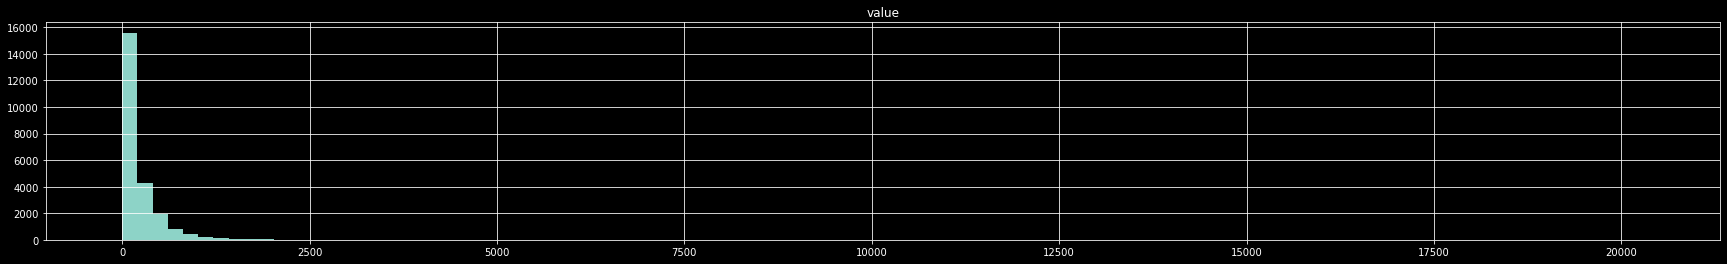

In [53]:
hist=items.hist(column="value",bins=100,figsize=(30, 4))

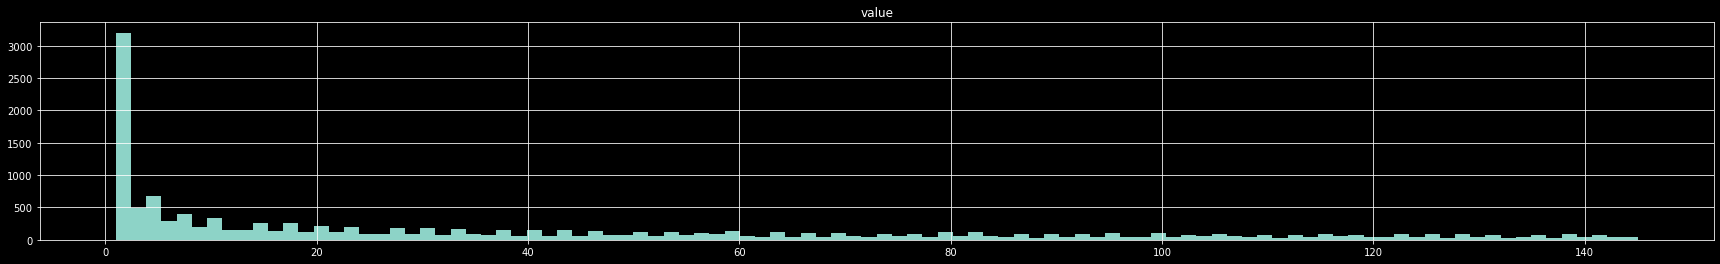

In [54]:
hist=items[10000:].hist(column="value",bins=100,figsize=(30, 4))

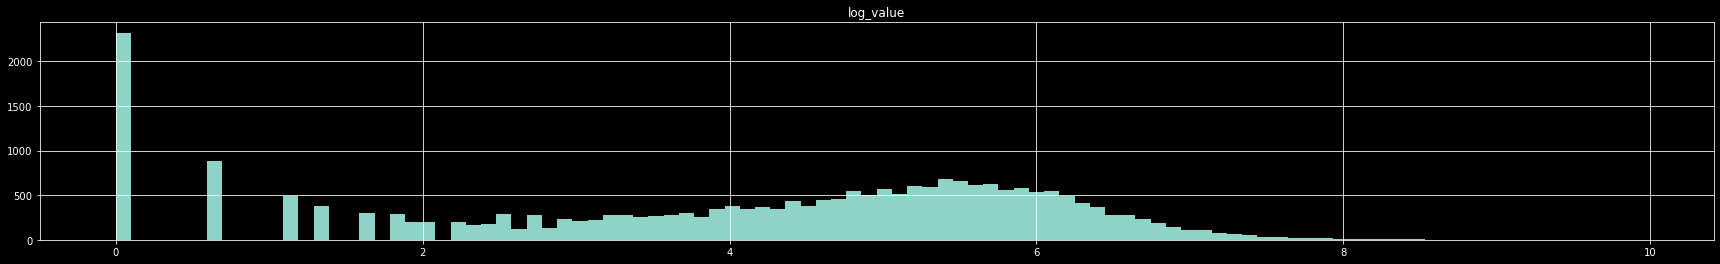

In [55]:
hist=items.hist(column="log_value",bins=100,figsize=(30, 4))

## TopPop Analisis

In [92]:
top_pop_general=items["item_id"][:100].values.tolist()

In [57]:
for item in top_pop_general:
    print(str(item)+",",end=" ")
print()


1468, 4741, 6135, 3526, 9262, 323, 3229, 3037, 2115, 3676, 1449, 6925, 16491, 1659, 786, 5960, 1227, 3531, 4810, 3746, 1393, 4411, 554, 4714, 3833, 2734, 3060, 4878, 1609, 4870, 540, 3306, 2180, 4935, 2549, 200, 190, 6006, 4213, 772, 11075, 1869, 2577, 2466, 3867, 4631, 3586, 917, 4796, 4645, 3400, 3362, 4026, 6345, 2233, 9661, 270, 3844, 4007, 11761, 2842, 4158, 2149, 3004, 11658, 8828, 2674, 2694, 18733, 2954, 3318, 17081, 2780, 3886, 10479, 407, 1584, 3656, 2546, 1285, 4503, 5215, 1725, 2530, 3155, 2320, 10738, 1336, 4036, 2638, 6785, 3783, 7597, 4057, 3095, 421, 1458, 18191, 15531, 232, 


In [58]:
train_sessions["month"] =train_sessions["date"].dt.month
train_sessions["year"] =train_sessions["date"].dt.year

In [59]:
monthly_ds=train_sessions.groupby(["month","year","item_id"])["value"].count().reset_index()

In [60]:
monthly_ds

,month,year,item_id,value
0,1,2020,30,27
1,1,2020,34,1
2,1,2020,62,4
3,1,2020,108,6
4,1,2020,186,80
...,...,...,...,...
124354,12,2020,23591,1
124355,12,2020,23595,1
124356,12,2020,23635,5
124357,12,2020,23655,1


In [61]:
top_pops={}
top_pops["general"]=top_pop_general

In [62]:
for year in range(2):
    year=year+2020
    for month in range(12):
        month+=1
        if year==2021 and month>5:
            break
        
        ds=monthly_ds[monthly_ds["month"]==month]
        ds=ds[ds["year"]==year]
        ds=ds.sort_values(by="value",ascending=False)
        top_pops[f"{month}/{year}"]=ds["item_id"][:100].values.tolist()

In [63]:
seen=[]
heatmap=np.zeros((len(top_pops.keys()),len(top_pops.keys())))
for x,i in enumerate(top_pops.keys()):
    for y,j in enumerate(top_pops.keys()):
        seen.append(i)
        if j not in seen:
            count=0
            for item in top_pops[i]:
                if item in top_pops[j]:
                    count+=1
            #print(f"items_in_common between {i} and {j}: {count}")
            heatmap[x,y]=count
            heatmap[y,x]=count

In [64]:
top_pops.keys()

dict_keys(['general', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021'])

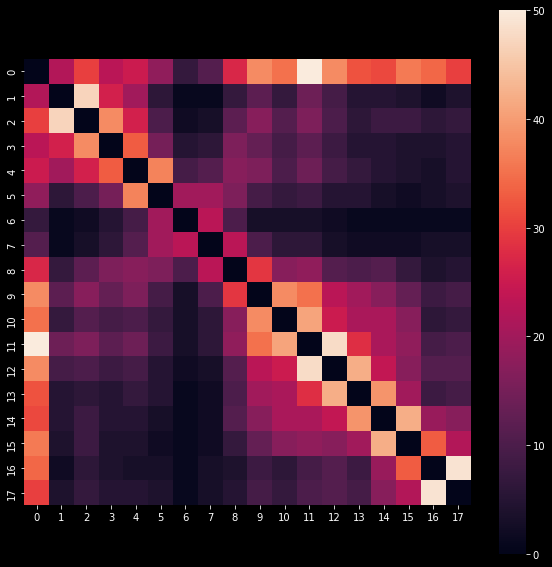

In [65]:
#0 is overall top_popular_list
#other numbers are the index of the month starting from january 2020 up to may 2021
#We can see that general top pop is close to november 2020 -> this can be due to the fact that is the month with most sessions
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(heatmap, square=True)

## Added test set to heatmap

In [66]:
items_test=test_sessions_no_duplicates.groupby("item_id")["value"].count().reset_index()
items_test=items_test.sort_values(by="value",ascending=False)
top_pop_test=items_test["item_id"][:100].values.tolist()

In [67]:
heatmap_test=np.zeros((len(top_pops.keys())+1,len(top_pops.keys())+1))

In [68]:
heatmap_test[:-1,:-1]=heatmap

In [69]:
for x,i in enumerate(top_pops.keys()):
    count=0
    for item in top_pops[i]:
        if item in top_pop_test:
            count+=1
    heatmap_test[-1,x] = count
    heatmap_test[x,-1] = count

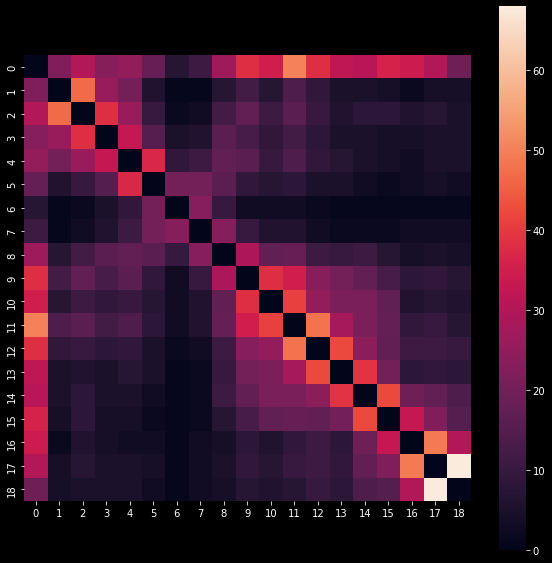

In [70]:
#last row/column are test set interaction top_pop
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(heatmap_test, square=True)

# Some additional analysis

In [100]:
strange_sessions=session[session["repeated_count"]>60]["item_id"].values

In [101]:
res={}
for i,s in enumerate(strange_sessions):
    res[f"{i}"]={}
    for item in s:
        if f"{item}" in res[f"{i}"]:
            res[f"{i}"][f"{item}"]+=1
        else:
            res[f"{i}"][f"{item}"]=1

In [102]:
res["0"]

{'3377': 38,
 '2535': 2,
 '3134': 26,
 '1135': 2,
 '2168': 1,
 '4077': 2,
 '2578': 1,
 '3197': 1,
 '3583': 1,
 '1922': 1,
 '3094': 2,
 '4571': 2,
 '4376': 1,
 '4587': 1,
 '4787': 1}

In [105]:
session[session["length_all"]>100]

,session_id,min,max,mean,item_id,length_all,length_unique,repeated_count,month,year,day_of_week,hour_start,hour_end,length,mean_minutes,length_hours,length_minutes
12190,54433,2020-06-18 01:07:58.123,2020-06-18 12:07:24.241,0 days 00:06:31.743742574,"[6300, 18038, 12002, 6190, 18854, 4411, 247, 4...",101,46,55,6,2020,3,1,12,0 days 10:59:26.118000,6,10,659
68427,305141,2021-05-15 17:09:00.693,2021-05-15 20:37:09.621,0 days 00:02:03.652752475,"[4411, 423, 4749, 887, 772, 4209, 2802, 4846, ...",101,57,44,5,2021,5,17,20,0 days 03:28:08.928000,2,3,208
204926,913190,2020-11-15 12:11:51.420,2020-11-15 18:43:32.957,0 days 00:03:52.688485148,"[18061, 14456, 5416, 17495, 10653, 16591, 1427...",101,91,10,11,2020,6,12,18,0 days 06:31:41.537000,3,6,391
690587,3067101,2020-02-20 07:16:12.776,2020-02-20 09:03:33.555,0 days 00:01:03.770089108,"[10003, 5922, 15520, 7258, 22831, 15387, 8747,...",101,82,19,2,2020,3,7,9,0 days 01:47:20.779000,1,1,107
836726,3715268,2020-12-17 14:02:29.557,2020-12-17 22:18:16.860,0 days 00:04:54.527752475,"[11699, 1285, 216, 4773, 3499, 4773, 17561, 24...",101,82,19,12,2020,3,14,22,0 days 08:15:47.303000,4,8,495
867524,3852385,2020-11-23 07:28:13.833,2020-11-23 17:15:28.775,0 days 00:05:48.860811881,"[693, 10551, 16084, 4821, 13355, 12666, 3264, ...",101,91,10,11,2020,0,7,17,0 days 09:47:14.942000,5,9,587
